In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from aerobot.io import RESULTS_PATH, load_results_dict, DATA_PATH
from aerobot.plot import plot_configure_mpl, ANNOTATION_BASED_FEATURE_TYPES, PRETTY_NAMES, plot_order_feature_types, plot_phylo_cv, plot_color_palette, plot_balanced_accuracy_axis
import os
from typing import Dict, List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plot_configure_mpl(figure_height=1.5)


%load_ext autoreload
%autoreload 2

In [2]:
# Load in the results of each training run. 
nonlinear_results = dict() # Results of Nonlinear classifier. 
logistic_results = dict() # Results of LogisticRegression-based classifier. 

# Only load results for a minimal list of feature types.
for feature_type in ['KO.geneset.terminal_oxidase', 'embedding.geneset.oxygen', 'KO', 'embedding.genome', 'chemical', 'aa_1mer', 'aa_3mer']:
    filename = f'train_nonlinear_{feature_type}_ternary.json'
    nonlinear_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, filename))
    filename = f'train_logistic_{feature_type}_ternary.json'
    logistic_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, filename))

In [3]:
# randrel_results = {'random relative':load_results_dict(os.path.join(RESULTS_PATH, f'phylo_cv_nonlinear_{feature_type}_ternary.json'))}
randrel_results = {'random relative':load_results_dict(os.path.join(RESULTS_PATH, f'phylo_cv_randrel_None_ternary.json'))}
taxonomy_coverage_df = pd.read_csv(os.path.join(DATA_PATH, 'earth_microbiome', 'taxonomy_coverage.csv'))

## Figure 1

In [4]:
def plot_figure_1a(grid:GridSpec=None, fig:plt.Figure=None):
    '''Just a placeholder, the diagram describing annotation-ful versus annotation-free pipelines for
    predicting metabolism will go here.'''
    ax = fig.add_subplot(grid)
    ax.set_axis_off()
    #ax.set_visible(False)
    return ax

In [5]:
def plot_figure_1b(randrel_results:Dict, taxonomy_coverage_df:pd.DataFrame, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot illustrating the predictive power of phylogeny. Will include a line indicating the performance of the RandomRelative classifier
    at each taxonomic level, as well as a line indicating taxonomy label coverage at each level.'''
    ax = fig.add_subplot(grid)
    ax.set_title('limits of phylogenetic classification')
    levels = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'] # Define the taxonomic levels. Kingdom is ommitted.

    colors = [plot_color_palette()['darkblue'], 'dimgray']

    plot_phylo_cv(randrel_results, ax=ax, color=colors[0])
    plot_balanced_accuracy_axis(ax, random_baseline=None) # Function returns the handles and labels for the legend.

    # Add another axis to the plot for showing taxonomy coverage. 
    right_ax = ax.twinx()
    right_ax.set_ylabel('coverage of EMP samples')
    n = len(taxonomy_coverage_df) # Number of habitats. 
    #right_ax.set_ylim([0, 1])
    
    x_vals = [i + 1 for i in range(len(levels))]
    y_vals = [taxonomy_coverage_df[level].mean() for level in levels[::-1]]
    errs = [taxonomy_coverage_df[level].std() / n for level in levels[::-1]] 
    right_ax.errorbar(x_vals, y_vals, yerr=errs, c=colors[1], capsize=3, ls='--')

    # Change the axes colors to match the lines. 
    right_ax.spines['left'].set_color(colors[0])
    right_ax.spines['right'].set_color(colors[1])

    
    for ax_, color in zip([ax, right_ax], colors):
        ax_.yaxis.label.set_color(color)
        ax_.tick_params(colors=color, axis='y')

    return ax

In [6]:
def plot_figure_1c(nonlinear_results:Dict, logistic_results:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot comparing Nonlinear and Logistic ternary classifier performance on the holdout set.'''

    ax = fig.add_subplot(grid)
    ax.set_title('validation of ML models')

    # Order the feature types in order of increasing validation accuracy. 
    order_by = {f:r['validation_acc'] for f, r in nonlinear_results.items()}
    feature_types = plot_order_feature_types(list(nonlinear_results.keys()), order_by=order_by)

    # Extract the final balanced accuracies on from the results dictionaries. 
    nonlinear_val_accs  = [nonlinear_results[feature_type]['validation_acc'] for feature_type in feature_types]
    logistic_val_accs  = [logistic_results[feature_type]['validation_acc'] for feature_type in feature_types]
    
    # Map annotation-free or -full features to different colors. 
    colors = [plot_color_palette()['blue'] if f in ANNOTATION_BASED_FEATURE_TYPES else plot_color_palette()['green'] for f in feature_types] 
    ax.bar(np.arange(0, len(feature_types), 1) - 0.2, logistic_val_accs, width=0.4, label='logistic', color=colors, edgecolor='k', linewidth=0.5, hatch='///')
    ax.bar(np.arange(0, len(feature_types), 1) + 0.2, nonlinear_val_accs, width=0.4, label='nonlinear', color=colors, edgecolor='k', linewidth=0.5)

    # Custom legend. Colors indicate annotation-free or annotation-full, and hatching indicates training or validation set. 
    handles = [plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch='////')]
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch=''))
    labels = ['linear', 'nonlinear']
    plt.legend(handles, labels, loc='lower right', framealpha=0.9)
    
    # Label bins with the feature name. 
    ax.set_xticks(np.arange(0, len(feature_types), 1), [PRETTY_NAMES[f] for f in feature_types], rotation=45, ha='right')

    plot_balanced_accuracy_axis(ax, random_baseline=None)

    # Add annotations indicating annotation-free or annotation-ful. 
    ax.text(3.1, 0.9, 'annotation-based', color=plot_color_palette()['darkblue'], ha='right', fontsize=6)
    ax.text(3.3, 0.9, 'annotation-free', color=plot_color_palette()['darkgreen'], ha='left', fontsize=6)

    return ax


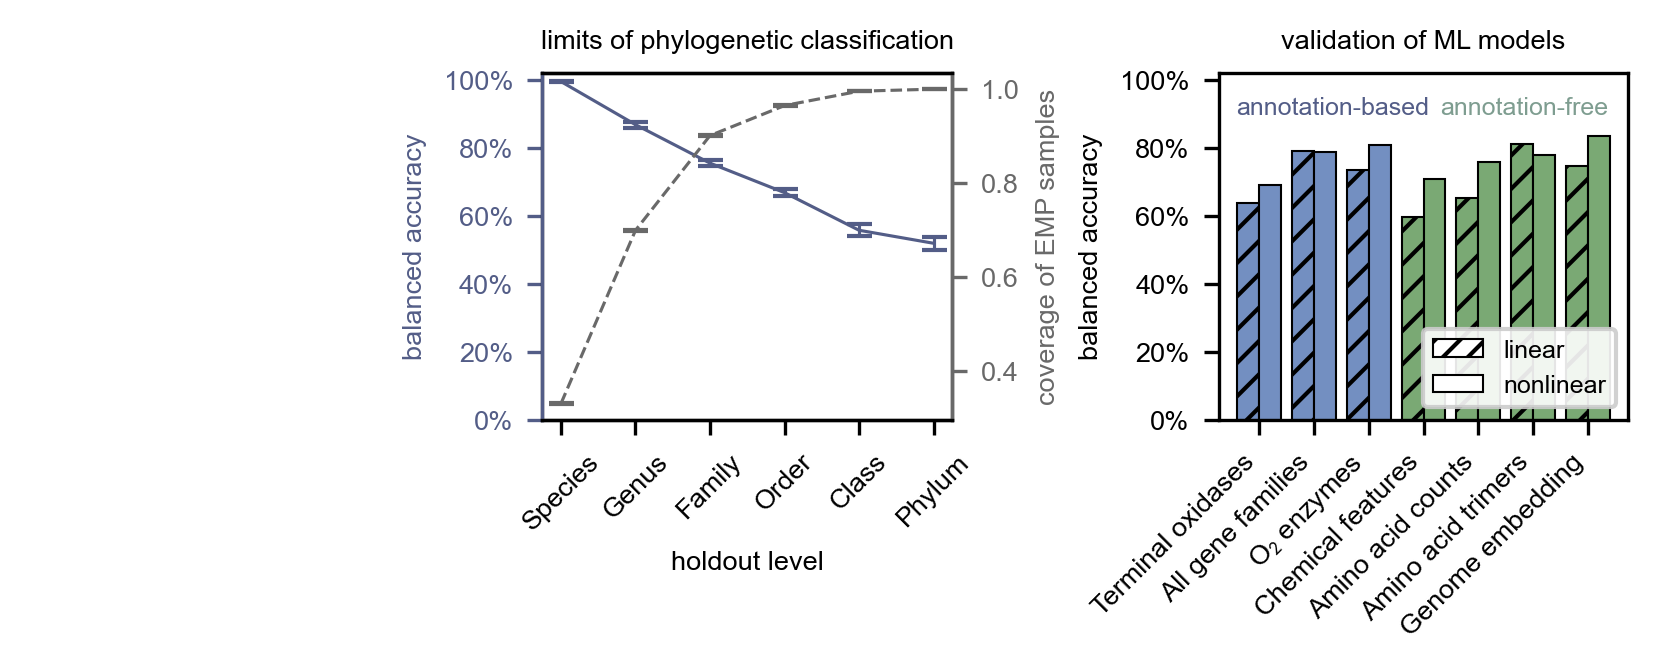

In [7]:
fig = plt.figure()
grid = GridSpec(1, 3, wspace=0.75, width_ratios=[0.6, 1, 1])

axes = []
axes.append(plot_figure_1a(grid=grid[0, 0], fig=fig))
axes.append(plot_figure_1b(randrel_results, taxonomy_coverage_df, grid=grid[0, 1], fig=fig))
axes.append(plot_figure_1c(nonlinear_results, logistic_results, grid=grid[0, 2], fig=fig))

#for ax, ax_label in zip(axes, 'ABC'):
#    if ax is not None:
#        ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig('../results/figures/fig1.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

In [8]:
print('Logistic accuracies: (training, validation)')
for feature_type, result in logistic_results.items():
    print(f'{PRETTY_NAMES[feature_type]}: {result["training_acc"]:.3f}, {result["validation_acc"]:.3f}')

Logistic accuracies: (training, validation)
Terminal oxidases: 0.630, 0.640
O$_2$ enzymes: 1.000, 0.734
All gene families: 1.000, 0.790
Genome embedding: 1.000, 0.749
Chemical features: 0.587, 0.596
Amino acid counts: 0.653, 0.654
Amino acid trimers: 1.000, 0.812


In [9]:
# print all the validation accuracies nicely
print('Nonlinear accuracies: (training, validation)')
for feature_type, result in nonlinear_results.items():
    print(f'{PRETTY_NAMES[feature_type]}: {result["training_acc"]:.3f}, {result["validation_acc"]:.3f}')

Nonlinear accuracies: (training, validation)
Terminal oxidases: 0.686, 0.691
O$_2$ enzymes: 0.905, 0.809
All gene families: 0.964, 0.788
Genome embedding: 0.871, 0.834
Chemical features: 0.680, 0.709
Amino acid counts: 0.780, 0.758
Amino acid trimers: 0.950, 0.779
